In [15]:
from transformers import pipeline

In [16]:
# Load the pre-trained models (DistilBERT cased, Roberta)
distilbert = pipeline("question-answering", model="distilbert-base-cased-distilled-squad")
roberta = pipeline("question-answering", model="deepset/roberta-base-squad2", tokenizer="deepset/roberta-base-squad2")

Device set to use mps:0
Device set to use mps:0


In [17]:
import json

# load dataset
with open('dataset.json', 'r') as file:
    test_data = json.load(file)

In [18]:
import time

In [19]:
distilbert_predictions = []
distilbert_times = []

for item in test_data:
    context = item['context']
    question = item['question']

    # Capture Distil BERT process time
    start_time = time.time()
    distilbert_answer = distilbert(question=question, context=context)
    end_time = time.time()
    distilbert_predictions.append(distilbert_answer['answer'])
    distilbert_times.append(end_time - start_time)

# Get the total process time of Distil BERT
total_distilbert_time = sum(distilbert_times)

In [20]:
roberta_predictions = []
roberta_times = []

for item in test_data:
    context = item['context']
    question = item['question']

    # Capture Roberta process time
    start_time = time.time()
    roberta_answer = roberta(question=question, context=context)
    end_time = time.time()
    roberta_predictions.append(roberta_answer['answer'])
    roberta_times.append(end_time - start_time)

# Get total process time of Roberta
total_roberta_time = sum(roberta_times)

In [21]:
print(f"Distil BERT process time: ", total_distilbert_time, "secs")
print(f"Roberta process time: ", total_roberta_time, "secs")

Distil BERT process time:  0.9046618938446045 secs
Roberta process time:  1.1059167385101318 secs


In [22]:
import re
import string
from collections import Counter


def remove_whitespace(text):
    """return removed white spaces text
    by splitting into words and join them again"""
    return ' '.join(text.split())


def remove_articles(text):
    """return removed articles text
    by using Regular Expression"""
    return re.sub(r'\b(a|an|the)\b', ' ', text)


def remove_punctuation(text):
    """return removed punctuation text
    by using string.punctuation"""
    return ''.join(ch for ch in text if ch not in set(string.punctuation))


def clean_answer(ans):
    """return lowercased text, removed punctuation,
    articles, and unnessary whitespaces."""
    return remove_whitespace(remove_articles(remove_punctuation(ans.lower())))

In [23]:
def f1_scores(prediction, true_answer):
    """return the f1 scores"""
    # split the model answers into a list
    pred_tokens = clean_answer(prediction).split()
    # split the true answers into a list
    truth_tokens = clean_answer(true_answer).split()
    # common token between model tokens and true tokens
    common = Counter(pred_tokens) & Counter(truth_tokens)
    sum_common = sum(common.values())
    if sum_common == 0:
        return 0
    precision = sum_common / len(pred_tokens)
    recall = sum_common / len(truth_tokens)
    f1 = 2 * (precision * recall) / (precision + recall)
    return f1



def exact_match_scores(prediction, true_answer):
    """Calculate Exact Match scores"""
    return clean_answer(prediction) == clean_answer(true_answer)

In [24]:
# Function to evaluate
def evaluate(model_answers, dataset):
    """Calculate f1 score and exact match"""
    total_f1 = 0
    total_em = 0
    for model_ans, item in zip(model_answers, dataset):
        # extract only answer section from dataset
        dataset_answers = item['answer']
        # get a highest value from the f1 scores
        f1 = max(f1_scores(model_ans, da) for da in dataset_answers)
        # get a highest value from the em scores
        em = max(exact_match_scores(model_ans, da) for da in dataset_answers)
        total_f1 += f1
        total_em += em
    f1 = total_f1 / len(dataset)
    exact_match = total_em / len(dataset)
    return {'exact_match': exact_match, 'f1': f1}

In [25]:
# Evaluate two models
distilbert_results = evaluate(distilbert_predictions, test_data)
roberta_results = evaluate(roberta_predictions, test_data)

print("DistilBERT base Results:", distilbert_results)
print("RoBERTa base Results:", roberta_results)

DistilBERT base Results: {'exact_match': 0.7, 'f1': 0.8664646464646465}
RoBERTa base Results: {'exact_match': 0.7666666666666667, 'f1': 0.893015873015873}


In [26]:
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd

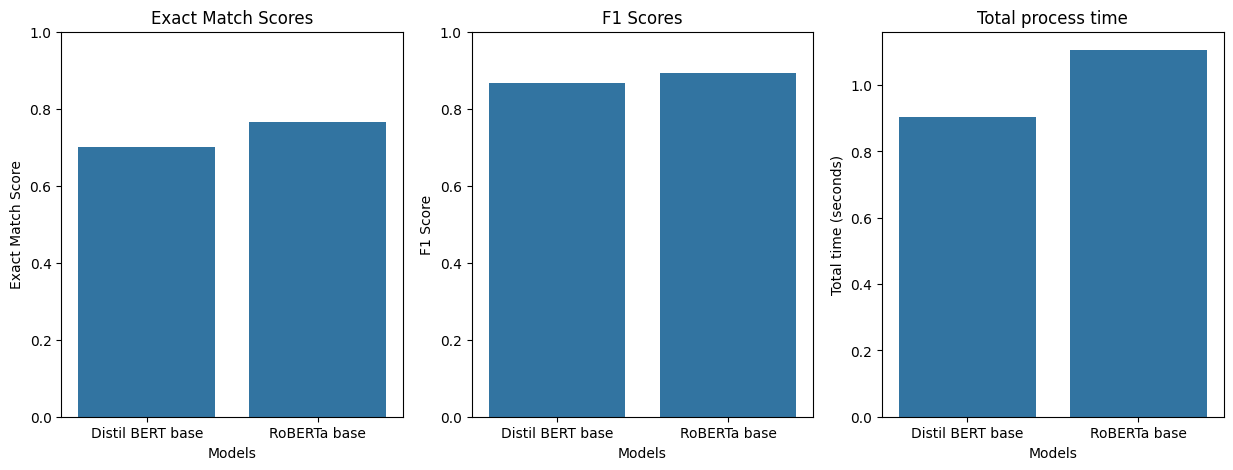

In [27]:
# Storing results as Dictionary
results = {
    "Model": ["Distil BERT base", "RoBERTa base"],
    "Exact Match": [distilbert_results['exact_match'], roberta_results['exact_match']],
    "F1 Score": [distilbert_results['f1'], roberta_results['f1']],
    "Time": [total_distilbert_time, total_roberta_time]
}

df = pd.DataFrame(results)

# Figure size
plt.figure(figsize=(15, 5))

# Exact Match Scores
plt.subplot(1, 3, 1)
sb.barplot(x="Model", y="Exact Match", data=df)
plt.title("Exact Match Scores")
plt.ylim(0, 1)
plt.ylabel("Exact Match Score")
plt.xlabel("Models")

# F1 Scores
plt.subplot(1, 3, 2)
sb.barplot(x="Model", y="F1 Score", data=df)
plt.title("F1 Scores")
plt.ylim(0, 1)
plt.ylabel("F1 Score")
plt.xlabel("Models")

# F1 Scores
plt.subplot(1, 3, 3)
sb.barplot(x="Model", y="Time", data=df)
plt.title("F1 Scores")
# plt.ylim(0, 1)
plt.title("Total process time")
plt.ylabel("Total time (seconds)")
plt.xlabel("Models")

# plt.tight_layout()
plt.show()